# Full waveform inversion by model extension (FWIME) - The Marmousi2 benchmark model

---
* Authors: Guillaume Barnier (barnier@gmail.com), Ettore Biondi (ebiondi@caltech.edu), and Stuart Farris (sfarris@sep.stanford.edu)
* Date: 05/12/2022
* Feel free to contact us if you have any questions

---
# I. Description
This Jupyter notebook allows you to reproduce the results shown in Barnier et al. (2022) using the Marmousi2 synthetic model (Martin et al., 2006). The notebook is organized with the following steps:
* Build velocity models
* Generate mask for gradient
* Conventional data-space mutli-scale FWI
* FWIME
* Results analysis
* References

# II. Experiment setup

## Import modules and libraries

In [1]:
# Import libraries
import genericIO
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
params = {
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14, 
    'legend.fontsize': 12,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
}
matplotlib.rcParams.update(params)

# Set the path for the executables
%env ACO_GPU_PACK=/opt/acoustic_2d/local/

# Set the path where the binaries will be written on disk
# %env DATAPATH=/net/vision/scr2/gbarnier/
%env LD_LIBRARY_PATH=/opt/acoustic_2d/local/lib/:/opt/elastic_2d/local/lib/:$LD_LIBRARY_PATH
%env PYTHONPATH=/opt/acoustic_2d/local/lib/python3.7:/opt/elastic_2d/local/lib/python3.7:$PYTHONPATH

env: ACO_GPU_PACK=/opt/acoustic_2d/local/
env: LD_LIBRARY_PATH=/opt/acoustic_2d/local/lib/:/opt/elastic_2d/local/lib/:$LD_LIBRARY_PATH
env: PYTHONPATH=/opt/acoustic_2d/local/lib/python3.7:/opt/elastic_2d/local/lib/python3.7:$PYTHONPATH


## Velocity models

In [2]:
# Read velocity models
vel_true = genericIO.defaultIO.getVector("vel/Marmousi2-trueVel.H")
vel_init = genericIO.defaultIO.getVector("vel/Marmousi2-initVel1.H")

# Get numpy array + hypecube info
vel_true_nd = vel_true.getNdArray()
vel_init_nd = vel_init.getNdArray()
vel_hyper = vel_true.getHyper()

# Get axes information
oz = vel_hyper.getAxis(1).o
dz = vel_hyper.getAxis(1).d
nz = vel_hyper.getAxis(1).n
ox = vel_hyper.getAxis(2).o
dx = vel_hyper.getAxis(2).d
nx = vel_hyper.getAxis(2).n

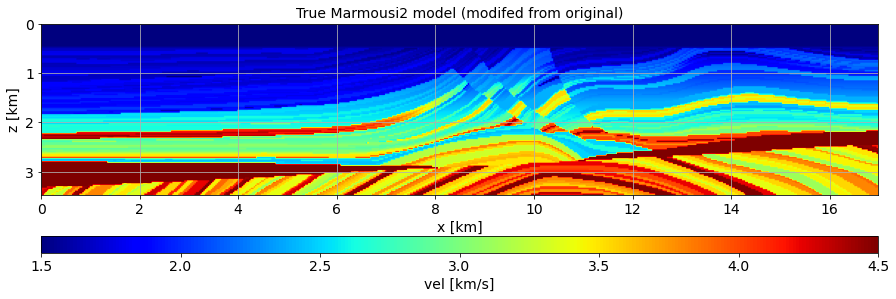

In [3]:
# Plot true velocity model
plt.figure(figsize=(15,5))
plt.imshow(vel_true_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect="equal")
plt.title("True Marmousi2 model (modifed from original)"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="vel [km/s]", aspect=50)
plt.grid()
plt.show()

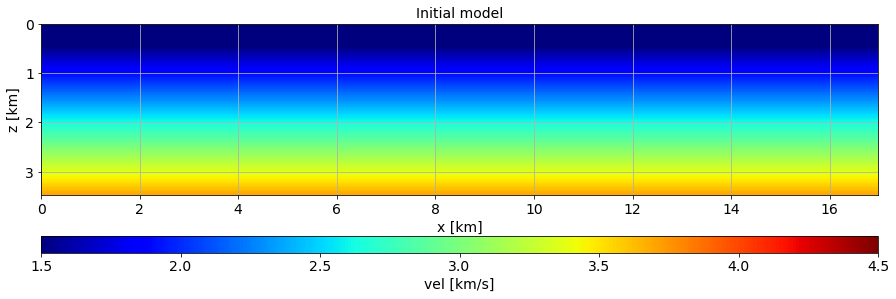

In [4]:
# Plot initial velocity model
plt.figure(figsize=(15,5))
plt.imshow(vel_init_nd.T,cmap='jet', vmin=1.5, vmax=4.5, extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz),aspect="equal")
plt.title("Initial model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="vel [km/s]", aspect=50)
plt.grid()
plt.show()

## Pad velocity models
In this numerical example, we use absorbing boundaries in all directions

In [5]:
%%bash
echo $DATAPATH
# Pad both initial and true velocity models (absorbing boundaries)
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=60 xPad=60 model=vel/Marmousi2-trueVel.H data=vel/Marmousi2-trueVel.pad.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=60 xPad=60 model=vel/Marmousi2-initVel1.H data=vel/Marmousi2-initVel1.pad.H

/tmp/
 
------------------------ Model padding program --------------------
Original nz = 117 [samples]
Original nx = 567 [samples]
 
zPadMinus = 60 [samples]
zPadPlus = 63 [samples]
xPadMinus = 60 [samples]
xPadPlus = 61 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 250 [samples including padding and FAT]
New nx = 698 [samples including padding and FAT]
-------------------------------------------------------------------
 
 
------------------------ Model padding program --------------------
Original nz = 117 [samples]
Original nx = 567 [samples]
 
zPadMinus = 60 [samples]
zPadPlus = 63 [samples]
xPadMinus = 60 [samples]
xPadPlus = 61 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 250 [samples including padding and FAT]
New nx = 698 [samples including padding and FAT]
-------------------------------------------------------------------
 


## Mask for gradient
We use a mask for the gradient to prevent the inversion from updating the velocity values in the water layer. The bathymetry is assumed to be know.

In [6]:
%%bash

# Create mask for gradient to prevent updates in the water layer
Vel n1=117 n2=567 n3=1 d1=1 d2=1 d3=1 o1=0.0 o2=0.0 o3=0.0 vc=1 > temp-mask1.H &&\
echo "d1=0.03 d2=0.03 d3=0.03" >> temp-mask1.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=60 xPad=60 model=temp-mask1.H data=temp-mask1.pad.H &&\
${ACO_GPU_PACK}/bin/maskGradientMain.py bufferUp=0.02 bufferDown=0.2 taperExp=2 wbShift=0.1 vel=./vel/Marmousi2-trueVel.pad.H model=temp-mask1.pad.H data=junk.H mask=./vel/Marmousi2-gradMask1.pad.H


 
------------------------ Model padding program --------------------
Original nz = 117 [samples]
Original nx = 567 [samples]
 
zPadMinus = 60 [samples]
zPadPlus = 63 [samples]
xPadMinus = 60 [samples]
xPadPlus = 61 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 250 [samples including padding and FAT]
New nx = 698 [samples including padding and FAT]
-------------------------------------------------------------------
 
--- User has not provided a gradient mask file ---
--- Automatically generating the mask from the provided parameters ---


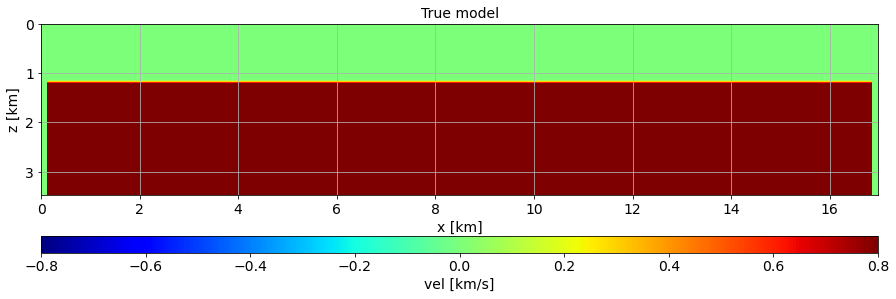

In [7]:
# Display mask with abosrbing boundaries
gradient_mask1 = genericIO.defaultIO.getVector("vel/Marmousi2-gradMask1.pad.H")
gradient_mask1_nd = gradient_mask1.getNdArray()
plt.figure(figsize=(15,5))
plt.imshow(gradient_mask1_nd.T,cmap='jet', vmin=-0.8, vmax=0.8, extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect="equal")
plt.title("True model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="vel [km/s]", aspect=50)
plt.grid()
plt.show()

## Create dummy velocity model 
We create this dummy file to pass the model dimension and hypercube information to the FWIME script and to the spline operator 

In [7]:
%%bash
Cp vel/Marmousi2-trueVel.pad.H vel/Marmousi2_velDummy.pad.H

# III. Conventional data-space multi-scale FWI

## Create wavelets

For simplicity, we generate 5 wavelets and datasets corresponding to each frequency band instead of generating one dataset and bandpassing every time


In [3]:
%%bash

############ Wavelets for conventional FWI ############
# For simplicity, we generate one wavelet and one dataset per frequency band
# 4-6 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/Marmousi2-fwi-4-13.p timeDelay=2.0 f1=4 f2=5 f3=5 f4=6 type=ali wavelet=wav/Marmousi2-wav-4-6.H &&\

# 4-7 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/Marmousi2-fwi-4-13.p timeDelay=2.0 f1=4 f2=5 f3=5.5 f4=7 type=ali wavelet=wav/Marmousi2-wav-4-7.H &&\

# 4-9 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/Marmousi2-fwi-4-13.p timeDelay=2.0 f1=4 f2=5 f3=7 f4=9 type=ali wavelet=wav/Marmousi2-wav-4-9.H &&\

# 4-11 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/Marmousi2-fwi-4-13.p timeDelay=2.0 f1=4 f2=5 f3=9 f4=11 type=ali wavelet=wav/Marmousi2-wav-4-11.H &&\

# 4-13 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/Marmousi2-fwi-4-13.p timeDelay=2.0 f1=4 f2=5 f3=10 f4=13 type=ali wavelet=wav/Marmousi2-wav-4-13.H


## Display wavelets time series

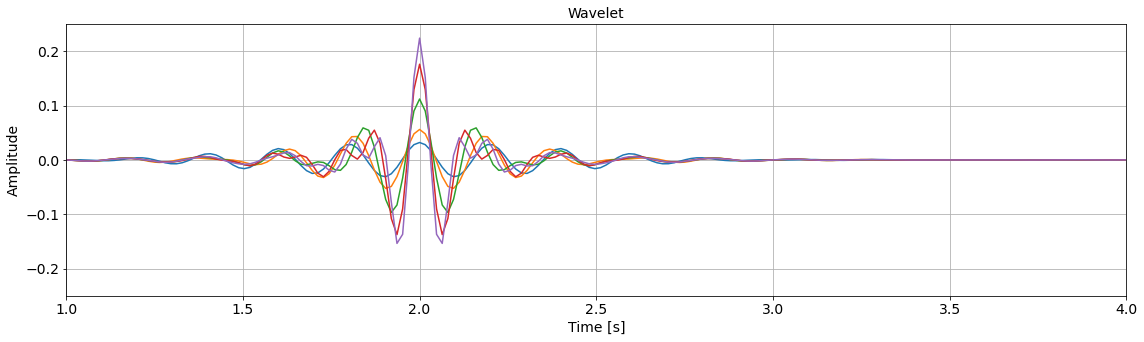

In [4]:
# Read wavelets 
wav_4_6 = genericIO.defaultIO.getVector("wav/Marmousi2-wav-4-6.H")
wav_4_7 = genericIO.defaultIO.getVector("wav/Marmousi2-wav-4-7.H")
wav_4_9 = genericIO.defaultIO.getVector("wav/Marmousi2-wav-4-9.H")
wav_4_11 = genericIO.defaultIO.getVector("wav/Marmousi2-wav-4-11.H")
wav_4_13 = genericIO.defaultIO.getVector("wav/Marmousi2-wav-4-13.H")

# Get numpy arrays
wav_4_6_Nd = wav_4_6.getNdArray()
wav_4_7_Nd = wav_4_7.getNdArray()
wav_4_9_Nd = wav_4_9.getNdArray()
wav_4_11_Nd = wav_4_11.getNdArray()
wav_4_13_Nd = wav_4_13.getNdArray()

# Get dimensions
wavelet_hyper = wav_4_6.getHyper()
time_axis = wavelet_hyper.getAxis(1)
nt = time_axis.n
ot = time_axis.o
dt = time_axis.d

# Display wavelets in time
fig, ax = plt.subplots(figsize=(19,5))
time_range = np.linspace(ot, ot+(nt-1)*dt, nt)
plt.plot(time_range, wav_4_6_Nd)
plt.plot(time_range, wav_4_7_Nd)
plt.plot(time_range, wav_4_9_Nd)
plt.plot(time_range, wav_4_11_Nd)
plt.plot(time_range, wav_4_13_Nd)
plt.title('Wavelet'), plt.xlabel("Time [s]"), plt.ylabel("Amplitude")
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim([-0.25, 0.25])
plt.xlim([1, 4])
plt.grid()
plt.show()



## Plot wavelet spectra

In [ ]:
%%bash

############### Create wavelet spectra ###############
Scale < wav/Marmousi2-wav-4-6.H | Spectra mag=dBnorm > t1.H &&\
Scale < wav/Marmousi2-wav-4-7.H | Spectra mag=dBnorm > t2.H &&\
Scale < wav/Marmousi2-wav-4-9.H | Spectra mag=dBnorm > t3.H &&\
Scale < wav/Marmousi2-wav-4-11.H | Spectra mag=dBnorm > t4.H &&\
Scale < wav/Marmousi2-wav-4-13.H | Spectra mag=dBnorm > t5.H &&\
Cat axis=2 t1.H t2.H t3.H t4.H t5.H > wav/Marmousi2_temp_spec.H


Spectra: error while loading shared libraries: libsepfft.so: cannot open shared object file: No such file or directory


In [4]:
# Read spectra
spectra = genericIO.defaultIO.getVector("wav/Marmousi2_temp_spec.H")
spectra_Nd = spectra.getNdArray()
spectraHyper = spectra.getHyper()

# Read dimensions
freq_axis = spectraHyper.getAxis(1)
nf = freq_axis.n
of = freq_axis.o
df = freq_axis.d

# Display wavelets in time
fig, ax = plt.subplots(figsize=(19,5))
freq_range = np.linspace(of, of+(nf-1)*df, nf)
plt.plot(freq_range, spectra_Nd.T)
plt.title('Wavelet spectra'), plt.xlabel("Frequency [Hz]"), plt.ylabel("Amplitude [dB]")
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim([-80, 5])
plt.xlim([0, 15])
plt.grid()
plt.show()


why exited 


RuntimeError: can not open file wav/Marmousi2_temp_spec.H

## Generate data
In this notebook, we generate noise-free acoustic isotropic constant-density pressure data 

In [14]:
%%bash

# 4-6 Hz
${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/Marmousi2-fwi-4-13.p vel=vel/Marmousi2-trueVel.pad.H model=wav/Marmousi2-wav-4-6.H data=dat/Marmousi2-data-4-6.H info=0 nGpu=4 &&\

# 4 - 7 Hz
${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/Marmousi2-fwi-4-13.p vel=vel/Marmousi2-trueVel.pad.H model=wav/Marmousi2-wav-4-7.H data=dat/Marmousi2-data-4-7.H info=0 nGpu=4 &&\

# 4-9 Hz
${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/Marmousi2-fwi-4-13.p vel=vel/Marmousi2-trueVel.pad.H model=wav/Marmousi2-wav-4-9.H data=dat/Marmousi2-data-4-9.H info=0 nGpu=4 &&\

# # 4-11 Hz
${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/Marmousi2-fwi-4-13.p vel=vel/Marmousi2-trueVel.pad.H model=wav/Marmousi2-wav-4-11.H data=dat/Marmousi2-data-4-11.H info=0 nGpu=4 &&\

# # 4-13 Hz
${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/Marmousi2-fwi-4-13.p vel=vel/Marmousi2-trueVel.pad.H model=wav/Marmousi2-wav-4-13.H data=dat/Marmousi2-data-4-13.H info=0 nGpu=4 

-------------------------------------------------------------------
------------------ Running Python nonlinear forward ---------------
-------------------- Single precision Python code -----------------
-------------------------------------------------------------------

-------------------------------------------------------------------
--------------------------- All done ------------------------------
-------------------------------------------------------------------

-------------------------------------------------------------------
------------------ Running Python nonlinear forward ---------------
-------------------- Single precision Python code -----------------
-------------------------------------------------------------------

-------------------------------------------------------------------
--------------------------- All done ------------------------------
-------------------------------------------------------------------

--------------------------------------------

/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will b

## Read and display data

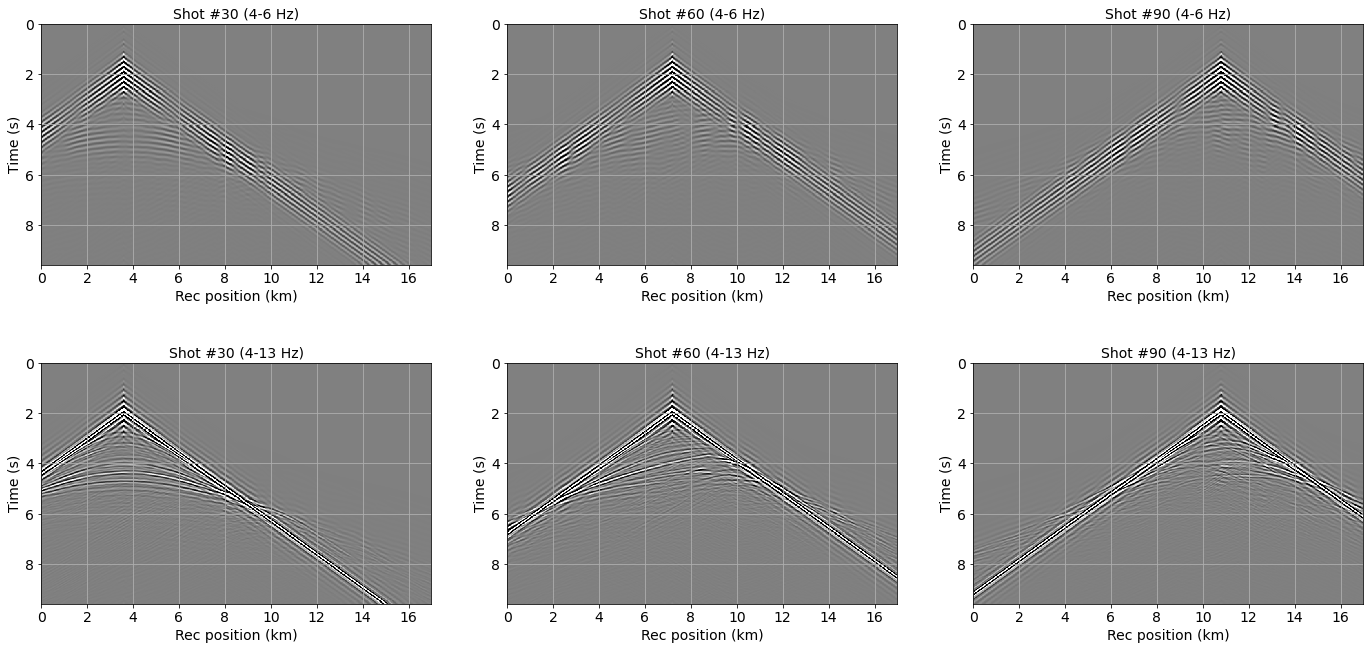

In [38]:
# Read data
data_4_6 = genericIO.defaultIO.getVector("dat/Marmousi2-data-4-6.H")
data_4_7 = genericIO.defaultIO.getVector("dat/Marmousi2-data-4-7.H")
data_4_9 = genericIO.defaultIO.getVector("dat/Marmousi2-data-4-9.H")
data_4_11 = genericIO.defaultIO.getVector("dat/Marmousi2-data-4-11.H")
data_4_13 = genericIO.defaultIO.getVector("dat/Marmousi2-data-4-13.H")

# Display data
data_4_6_nd = data_4_6.getNdArray()
data_4_7_nd = data_4_7.getNdArray()
data_4_9_nd = data_4_9.getNdArray()
data_4_11_nd = data_4_11.getNdArray()
data_4_13_nd = data_4_13.getNdArray()

# Clipping
pclip=98
clip = np.percentile(np.abs(data_4_13_nd), pclip)

# Dimensions
o_rec = data_4_6.getHyper().getAxis(2).o
d_rec = data_4_6.getHyper().getAxis(2).d
n_rec = data_4_6.getHyper().getAxis(2).n
rec_range = np.linspace(o_rec, o_rec+(n_rec-1)*d_rec, n_rec)

# Display shot gathers
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# First frequency band: 4-6 Hz
shot1 = 30
axs[0,0].pcolormesh(rec_range, time_range, data_4_6_nd[shot1].T,vmin=-clip,vmax=clip)
axs[0,0].invert_yaxis()
axs[0,0].grid()
axs[0,0].set_ylabel('Time (s)')
axs[0,0].set_xlabel('Rec position (km)')
axs[0,0].set_title('Shot #' + str(shot1) + " (4-6 Hz)")

shot2 = 60
axs[0,1].pcolormesh(rec_range, time_range, data_4_6_nd[shot2].T,vmin=-clip,vmax=clip)
axs[0,1].invert_yaxis()
axs[0,1].grid()
axs[0,1].set_ylabel('Time (s)')
axs[0,1].set_xlabel('Rec position (km)')
axs[0,1].set_title('Shot #' + str(shot2) + " (4-6 Hz)")

shot3 = 90
axs[0,2].pcolormesh(rec_range, time_range, data_4_6_nd[shot3].T,vmin=-clip,vmax=clip)
axs[0,2].invert_yaxis()
axs[0,2].grid()
axs[0,2].set_ylabel('Time (s)')
axs[0,2].set_xlabel('Rec position (km)')
axs[0,2].set_title('Shot #' + str(shot3) + " (4-6 Hz)")

# Last frequency band: 4-13 Hz
axs[1,0].pcolormesh(rec_range, time_range, data_4_13_nd[shot1].T,vmin=-clip,vmax=clip)
axs[1,0].invert_yaxis()
axs[1,0].grid()
axs[1,0].set_ylabel('Time (s)')
axs[1,0].set_xlabel('Rec position (km)')
axs[1,0].set_title('Shot #' + str(shot1) + " (4-13 Hz)")

axs[1,1].pcolormesh(rec_range, time_range, data_4_13_nd[shot2].T,vmin=-clip,vmax=clip)
axs[1,1].invert_yaxis()
axs[1,1].grid()
axs[1,1].set_ylabel('Time (s)')
axs[1,1].set_xlabel('Rec position (km)')
axs[1,1].set_title('Shot #' + str(shot2) + " (4-13 Hz)")

axs[1,2].pcolormesh(rec_range, time_range, data_4_13_nd[shot3].T,vmin=-clip,vmax=clip)
axs[1,2].invert_yaxis()
axs[1,2].grid()
axs[1,2].set_ylabel('Time (s)')
axs[1,2].set_xlabel('Rec position (km)')
axs[1,2].set_title('Shot #' + str(shot3) + " (4-13 Hz)")

plt.tight_layout(pad=3.0)
plt.show()

## Conventional data-space multi-scale FWI
* We apply conventional data-space multi-scale FWI using 5 frequency bands: 4-6 Hz, 4-7 Hz, 4-9 Hz, and 4-13 Hz
* We show that FWI converges to an unsatisfactory solution

In [18]:
%%bash

# 4-6 Hz
${ACO_GPU_PACK}/bin/fwiMain.py par=par/Marmousi2-fwi-4-13.p sources=wav/Marmousi2-wav-4-6.H vel=vel/Marmousi2-initVel1.pad.H data=dat/Marmousi2-data-4-6.H nIter=3 folder=Marmousi2-fwi-4-6Hz minBound=1.3 maxBound=5.0 nGpu=4 solver=lbfgs &&\

# 4-7 Hz
${ACO_GPU_PACK}/bin/fwiMain.py par=par/Marmousi2-fwi-4-13.p sources=wav/Marmousi2-wav-4-7.H vel=Marmousi2-fwi-4-6Hz/Marmousi2-fwi-4-6Hz_inv_mod.H data=dat/Marmousi2-data-4-7.H nIter=3 folder=Marmousi2-fwi-4-7Hz minBound=1.3 maxBound=5.0 nGpu=4 solver=lbfgs &&\

# 4-9 Hz
${ACO_GPU_PACK}/bin/fwiMain.py par=par/Marmousi2-fwi-4-13.p sources=wav/Marmousi2-wav-4-9.H vel=Marmousi2-fwi-4-7Hz/Marmousi2-fwi-4-7Hz_inv_mod.H data=dat/Marmousi2-data-4-9.H nIter=3 folder=Marmousi2-fwi-4-9Hz minBound=1.3 maxBound=5.0 nGpu=4 solver=lbfgs &&\

# 4-11 Hz
${ACO_GPU_PACK}/bin/fwiMain.py par=par/Marmousi2-fwi-4-13.p sources=wav/Marmousi2-wav-4-11.H vel=Marmousi2-fwi-4-9Hz/Marmousi2-fwi-4-9Hz_inv_mod.H data=dat/Marmousi2-data-4-11.H nIter=3 folder=Marmousi2-fwi-4-11Hz minBound=1.3 maxBound=5.0 nGpu=4 solver=lbfgs &&\

# 4-13 Hz
${ACO_GPU_PACK}/bin/fwiMain.py par=par/Marmousi2-fwi-4-13.p sources=wav/Marmousi2-wav-4-13.H vel=Marmousi2-fwi-4-11Hz/Marmousi2-fwi-4-11Hz_inv_mod.H data=dat/reproMaMarmousi2rmousi-data-4-13.H nIter=3 folder=Marmousi2-fwi-4-13Hz minBound=1.3 maxBound=5.0 nGpu=4 solver=lbfgs

-------------------------------------------------------------------
------------------------ Conventional FWI -------------------------
-------------------------------------------------------------------

--- Using gradient masking ---
--- User has provided a gradient mask file ---
##########################################################################################
Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm 
Restart folder: /net/vision/scr2/gbarnier/restart_2022-05-12T20-17-15.539523/
##########################################################################################

iter = 0, obj = 3.69753e-07, resnorm = 8.60e-04, gradnorm = 1.26e-08, feval = 1, geval = 1
iter = 1, obj = 3.00768e-07, resnorm = 7.76e-04, gradnorm = 1.04e-08, feval = 2, geval = 2
iter = 2, obj = 2.09662e-07, resnorm = 6.48e-04, gradnorm = 1.13e-08, feval = 3, geval = 3
iter = 3, obj = 1.86110e-07, resnorm = 6.10e-04, gradnorm = 7.49e-09, feval = 4, geval = 4
Terminate: maximum number of iterations r

/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will b

## Display FWI results

### Objective functions

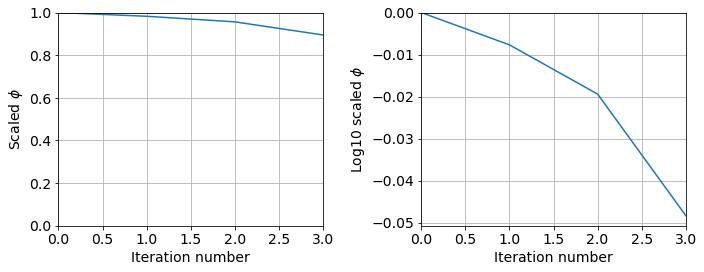

In [20]:
############# FWI Objective functions #############
# Read file 
obj_fwi_4_6 = genericIO.defaultIO.getVector("Marmousi2-fwi-4-6Hz/Marmousi2-fwi-4-6Hz_obj.H")
obj_fwi_4_7 = genericIO.defaultIO.getVector("Marmousi2-fwi-4-7Hz/Marmousi2-fwi-4-7Hz_obj.H")
obj_fwi_4_9 = genericIO.defaultIO.getVector("Marmousi2-fwi-4-9Hz/Marmousi2-fwi-4-9Hz_obj.H")
obj_fwi_4_11 = genericIO.defaultIO.getVector("Marmousi2-fwi-4-11Hz/Marmousi2-fwi-4-11Hz_obj.H")
obj_fwi_4_13 = genericIO.defaultIO.getVector("Marmousi2-fwi-4-13Hz/Marmousi2-fwi-4-13Hz_obj.H")

# Convert SEP array to numpy array
obj_fwi_4_6_nd = obj_fwi_4_6.getNdArray()
obj_fwi_4_7_nd = obj_fwi_4_7.getNdArray()
obj_fwi_4_9_nd = obj_fwi_4_9.getNdArray()
obj_fwi_4_11_nd = obj_fwi_4_11.getNdArray()
obj_fwi_4_13_nd = obj_fwi_4_13.getNdArray()

# Plot normalized objective function
fwi_obj = obj_fwi_4_6_nd
fwi_obj_norm = fwi_obj/fwi_obj[0]
plt.figure(figsize=(10,4))

# Normal scale
plt.subplot(121)
plt.plot(fwi_obj_norm)
plt.xlabel("Iteration number",fontsize=14)
plt.ylabel("Scaled $\phi$",fontsize=14)
ax = plt.gca() 
plt.ylim([0,1])
plt.grid()
ax.autoscale(enable=True, axis='x', tight=True)

# Log scale
plt.subplot(122)
plt.plot(np.log10(fwi_obj_norm))
plt.xlabel("Iteration number",fontsize=14)
plt.ylabel("Log10 scaled $\phi$",fontsize=14)
ax = plt.gca() 
plt.ylim([None,0])
plt.grid()
ax.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()



### FWI inverted models for each frequency band

In [21]:
%%bash

# Remove absorbing boundary padding from inverted models
Window3d n1=117 f1=65 n2=567 f2=65 < Marmousi2-fwi-4-6Hz/Marmousi2-fwi-4-6Hz_inv_mod.H > Marmousi2_inv_mod_4_6.H &&\
Window3d n1=117 f1=65 n2=567 f2=65 < Marmousi2-fwi-4-7Hz/Marmousi2-fwi-4-7Hz_inv_mod.H > Marmousi2_inv_mod_4_7.H &&\
Window3d n1=117 f1=65 n2=567 f2=65 < Marmousi2-fwi-4-9Hz/Marmousi2-fwi-4-9Hz_inv_mod.H > Marmousi2_inv_mod_4_9.H &&\
Window3d n1=117 f1=65 n2=567 f2=65 < Marmousi2-fwi-4-11Hz/Marmousi2-fwi-4-11Hz_inv_mod.H > Marmousi2_inv_mod_4_11.H &&\
Window3d n1=117 f1=65 n2=567 f2=65 < Marmousi2-fwi-4-13Hz/Marmousi2-fwi-4-13Hz_inv_mod.H > Marmousi2_inv_mod_4_13.H


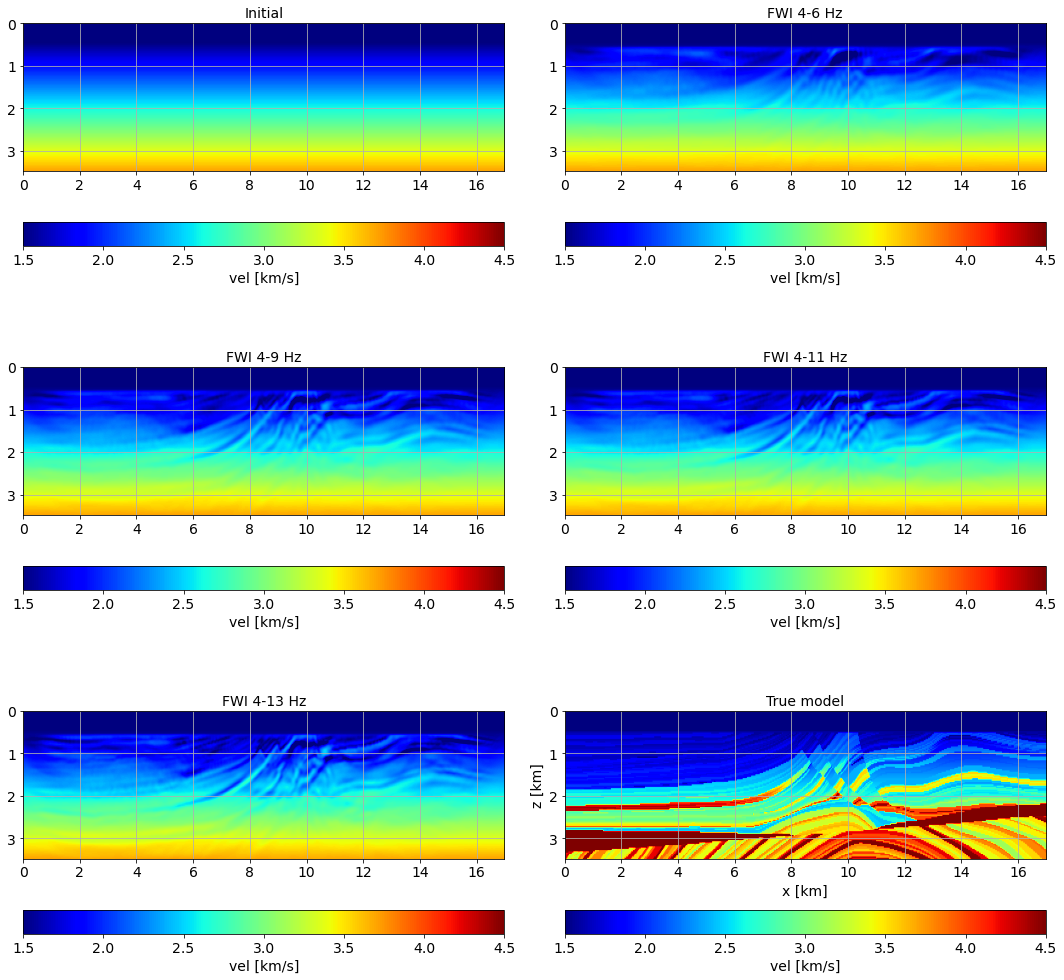

In [32]:
# Read inverted models
model_4_6 = genericIO.defaultIO.getVector("Marmousi2_inv_mod_4_6.H")
model_4_7 = genericIO.defaultIO.getVector("Marmousi2_inv_mod_4_7.H")
model_4_9 = genericIO.defaultIO.getVector("Marmousi2_inv_mod_4_9.H")
model_4_11 = genericIO.defaultIO.getVector("Marmousi2_inv_mod_4_11.H")
model_4_13 = genericIO.defaultIO.getVector("Marmousi2_inv_mod_4_13.H")

# Convert SEP arrays to numpy arrays
model_4_6_nd = model_4_6.getNdArray()
model_4_7_nd = model_4_7.getNdArray()
model_4_9_nd = model_4_9.getNdArray()
model_4_11_nd = model_4_11.getNdArray()
model_4_13_nd = model_4_13.getNdArray()

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plot Initial velocity model
img0_0 = axs[0,0].imshow(vel_init_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[0,0].set_title("Initial"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img0_0, ax=axs[0,0], orientation="horizontal", label="vel [km/s]")
axs[0,0].grid()

# Plot 4-6 Hz velocity model
img0_1 = axs[0,1].imshow(model_4_6_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[0,1].set_title("FWI 4-6 Hz"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img0_1, ax=axs[0,1], orientation="horizontal", label="vel [km/s]")
axs[0,1].grid()

# Plot 4-9 Hz velocity model
img1_0 = axs[1,0].imshow(model_4_9_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[1,0].set_title("FWI 4-9 Hz"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img1_0, ax=axs[1,0], orientation="horizontal", label="vel [km/s]")
axs[1,0].grid()

# Plot 4-11 Hz velocity model
img1_1 = axs[1,1].imshow(model_4_11_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[1,1].set_title("FWI 4-11 Hz"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img1_1, ax=axs[1,1], orientation="horizontal", label="vel [km/s]")
axs[1,1].grid()

# Plot 4-13 Hz velocity model
img2_0 = axs[2,0].imshow(model_4_13_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[2,0].set_title("FWI 4-13 Hz"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img2_0, ax=axs[2,0], orientation="horizontal", label="vel [km/s]")
axs[2,0].grid()

# Plot true velocity model
img2_1 = axs[2,1].imshow(vel_true_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[2,1].set_title("True model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img2_1, ax=axs[2,1], orientation="horizontal", label="vel [km/s]")
axs[2,1].grid()


plt.tight_layout()
    


# IV. FWIME

## Wavelet 
* The frequency content is identical to the one used for the last band of conventional FWI
* The recording time is set to 8 s compared to 9.5 s for FWI (to make the experiment even more difficult)

In [39]:
%%bash

############ Wavelet for FWIME ############
# 4-13 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/Marmousi2-fwime-4-13.p timeDelay=1.2 f1=4 f2=6 f3=10 f4=13 type=ali wavelet=wav/Marmousi2-fwime-wav-4-13.H

## Data 
* The frequency content is identical to the one used for the last band of conventional FWI
* The recording time is set to 8 s compared to 9.5 s for FWI

In [41]:
%%bash

############ Data ############
${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/Marmousi2-fwime-4-13.p vel=vel/Marmousi2-trueVel.pad.H model=wav/Marmousi2-fwime-wav-4-13.H data=dat/Marmousi2-fwime-data-4-13.H info=0 nGpu=4

-------------------------------------------------------------------
------------------ Running Python nonlinear forward ---------------
-------------------- Single precision Python code -----------------
-------------------------------------------------------------------

-------------------------------------------------------------------
--------------------------- All done ------------------------------
-------------------------------------------------------------------



/opt/conda/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Upper and lower velocity bounds computation
* We choose lower/upper velocity values $v_{min}$ and $v_{max}$ to prevent the velocity model from taking values that would create FD instability or dispersion
* However, the step length calculation and the model updates are conducted on the spline grid (see Barnier et. al, 2022), so we need to express these bounds on the spline grid
* For each spline grid, we create two constant velocity models on the FD grid whose values are set to $v_{min}$ and $v_{max}$, respectively
* We map these constant velocity models onto the spline grid by applying the adjoint of the spline mapping operator
* We use the output of this adjoint mapping as lower/upper bounds on the spline grid (which is where our unknown model is parametrized)

In [1]:
%%bash

################### Bounds for spline grid 1 ###################
# Max bound
# On the FD, create constant model whose value is set to vmax = 5 km/s
Vel n1=115 n2=567 n3=1 d1=0.03 d2=0.03 d3=0.03 vc=5.0 > junkMax.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=60 xPad=60 model=junkMax.H data=junkMax.pad.H &&\
# Map the constant velocity model from the FD grid to the current spline grid by applying the adjoint of the spline interpolation operator (adj=1)
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=junkMax.pad.H model=vel/Marmousi2-fwime-4-13-spline1-maxBound.H adj=1 par=par/Marmousi2-fwime-4-13-spline1.p vel=vel/Marmousi2_velDummy.pad.H

# Min bound
Vel n1=115 n2=567 n3=1 d1=0.03 d2=0.03 d3=0.03 vc=1.3 > junkMin.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=60 xPad=60 model=junkMin.H data=junkMin.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=junkMin.pad.H model=vel/Marmousi2-fwime-4-13-spline1-minBound.H adj=1 par=par/Marmousi2-fwime-4-13-spline1.p vel=vel/Marmousi2_velDummy.pad.H

################### Bounds for spline grid 2 ###################
# Max bound
Vel n1=115 n2=567 n3=1 d1=0.03 d2=0.03 d3=0.03 vc=5.0 > junkMax.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=60 xPad=60 model=junkMax.H data=junkMax.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=junkMax.pad.H model=vel/Marmousi2-fwime-4-13-spline2-maxBound.H adj=1 par=par/Marmousi2-fwime-4-13-spline2.p vel=vel/Marmousi2_velDummy.pad.H

# Min bound
Vel n1=115 n2=567 n3=1 d1=0.03 d2=0.03 d3=0.03 vc=1.3 > junkMin.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=60 xPad=60 model=junkMin.H data=junkMin.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=junkMin.pad.H model=vel/Marmousi2-fwime-4-13-spline2-minBound.H adj=1 par=par/Marmousi2-fwime-4-13-spline2.p vel=vel/Marmousi2_velDummy.pad.H

################### Bounds for spline grid 3 ###################
# Max bound
Vel n1=115 n2=567 n3=1 d1=0.03 d2=0.03 d3=0.03 vc=5.0 > junkMax.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=60 xPad=60 model=junkMax.H data=junkMax.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=junkMax.pad.H model=vel/Marmousi2-fwime-4-13-spline3-maxBound.H adj=1 par=par/Marmousi2-fwime-4-13-spline3.p vel=vel/Marmousi2_velDummy.pad.H

# Min bound
Vel n1=115 n2=567 n3=1 d1=0.03 d2=0.03 d3=0.03 vc=1.3 > junkMin.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=60 xPad=60 model=junkMin.H data=junkMin.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=junkMin.pad.H model=vel/Marmousi2-fwime-4-13-spline3-minBound.H adj=1 par=par/Marmousi2-fwime-4-13-spline3.p vel=vel/Marmousi2_velDummy.pad.H



bash: line 6: /bin/padFileGpuMain: No such file or directory


CalledProcessError: Command 'b'\n################### Bounds for spline grid 1 ###################\n# Max bound\n# On the FD, create constant model whose value is set to vmax = 5 km/s\nVel n1=115 n2=567 n3=1 d1=0.03 d2=0.03 d3=0.03 vc=5.0 > junkMax.H &&\\\n${ACO_GPU_PACK}/bin/padFileGpuMain zPad=60 xPad=60 model=junkMax.H data=junkMax.pad.H &&\\\n# Map the constant velocity model from the FD grid to the current spline grid by applying the adjoint of the spline interpolation operator (adj=1)\n${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=junkMax.pad.H model=vel/reproMarmousi-fwime-4-13-spline1-maxBound.H adj=1 par=par/reproMarmousi-fwime-4-13-spline1.p vel=vel/reproMarmousi_velDummy.pad.H\n\n# Min bound\nVel n1=115 n2=567 n3=1 d1=0.03 d2=0.03 d3=0.03 vc=1.3 > junkMin.H &&\\\n${ACO_GPU_PACK}/bin/padFileGpuMain zPad=60 xPad=60 model=junkMin.H data=junkMin.pad.H &&\\\n${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=junkMin.pad.H model=vel/reproMarmousi-fwime-4-13-spline1-minBound.H adj=1 par=par/reproMarmousi-fwime-4-13-spline1.p vel=vel/reproMarmousi_velDummy.pad.H\n\n################### Bounds for spline grid 2 ###################\n# Max bound\nVel n1=115 n2=567 n3=1 d1=0.03 d2=0.03 d3=0.03 vc=5.0 > junkMax.H &&\\\n${ACO_GPU_PACK}/bin/padFileGpuMain zPad=60 xPad=60 model=junkMax.H data=junkMax.pad.H &&\\\n${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=junkMax.pad.H model=vel/reproMarmousi-fwime-4-13-spline2-maxBound.H adj=1 par=par/reproMarmousi-fwime-4-13-spline2.p vel=vel/reproMarmousi_velDummy.pad.H\n\n# Min bound\nVel n1=115 n2=567 n3=1 d1=0.03 d2=0.03 d3=0.03 vc=1.3 > junkMin.H &&\\\n${ACO_GPU_PACK}/bin/padFileGpuMain zPad=60 xPad=60 model=junkMin.H data=junkMin.pad.H &&\\\n${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=junkMin.pad.H model=vel/reproMarmousi-fwime-4-13-spline2-minBound.H adj=1 par=par/reproMarmousi-fwime-4-13-spline2.p vel=vel/reproMarmousi_velDummy.pad.H\n\n################### Bounds for spline grid 3 ###################\n# Max bound\nVel n1=115 n2=567 n3=1 d1=0.03 d2=0.03 d3=0.03 vc=5.0 > junkMax.H &&\\\n${ACO_GPU_PACK}/bin/padFileGpuMain zPad=60 xPad=60 model=junkMax.H data=junkMax.pad.H &&\\\n${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=junkMax.pad.H model=vel/reproMarmousi-fwime-4-13-spline3-maxBound.H adj=1 par=par/reproMarmousi-fwime-4-13-spline3.p vel=vel/reproMarmousi_velDummy.pad.H\n\n# Min bound\nVel n1=115 n2=567 n3=1 d1=0.03 d2=0.03 d3=0.03 vc=1.3 > junkMin.H &&\\\n${ACO_GPU_PACK}/bin/padFileGpuMain zPad=60 xPad=60 model=junkMin.H data=junkMin.pad.H &&\\\n${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=junkMin.pad.H model=vel/reproMarmousi-fwime-4-13-spline3-minBound.H adj=1 par=par/reproMarmousi-fwime-4-13-spline3.p vel=vel/reproMarmousi_velDummy.pad.H\n\n'' returned non-zero exit status 127.

## FWIME on spline grid 1

### Generate initial model onto first spline grid
* In step II of this notebook, we created/read the initial velocity model $\mathbf{m}^f_{init}$ defined on the (fine) FD grid 
* We now need to convert it (or map it) onto the first coarse spline grid $c_1$ in order to obtain the initial model for the FWIME inversion, $\mathbf{m}^{c_1}_{init}$
* The mapping is done by finding the unique minimizer of the following loss function:

$\mathbf{m}^{c_1}_{init} = \underset{\mathbf{m}^{c_1}}{\mathrm{argmin}} \; \dfrac{1}{2} \left \| \mathbf{S}_1 \mathbf{m}^{c_1} - \mathbf{m}^f_{init} \right \|_2^2$
* $\mathbf{S}_1$ is the spline mapping operator (from the first coarse spline grid -> fine grid)
* $\mathbf{m}^{c_1}$ corresponds to any model defined on the first spline grid


In [43]:
%%bash

# Create directory spline2dJunk (you might have to create it manually by typing "mkdir spline2dJunk")
# Map initial model onto the first spline grid
${ACO_GPU_PACK}/bin/interpBSplineInvMain.py nDim=2 nIter=50 folder=spline2dJunk vel=vel/Marmousi2_velDummy.pad.H data=vel/Marmousi2-initVel1.pad.H par=par/Marmousi2-fwime-4-13-spline1.p &&\
Cp spline2dJunk/spline2dJunk_inv_mod.H vel/Marmousi2-fwime-4-13-coarseInitMod-spline1.H


##########################################################################################
				LINEAR CONJUGATE GRADIENT  SOLVER
	Restart folder: /net/vision/scr2/gbarnier/restart_2022-05-12T20-56-32.223178/
	Modeling Operator:		Operator
##########################################################################################

iter = 00, obj = 6.06367e+05, resnorm = 1.10e+03, gradnorm = 1.10e+03, feval = 2
iter = 01, obj = 4.35356e+00, resnorm = 2.95e+00, gradnorm = 2.41e+00, feval = 4
iter = 02, obj = 7.97024e-01, resnorm = 1.26e+00, gradnorm = 6.06e-01, feval = 6
iter = 03, obj = 4.14188e-01, resnorm = 9.10e-01, gradnorm = 3.30e-01, feval = 8
iter = 04, obj = 2.61415e-01, resnorm = 7.23e-01, gradnorm = 2.08e-01, feval = 10
iter = 05, obj = 2.07482e-01, resnorm = 6.44e-01, gradnorm = 1.31e-01, feval = 12
iter = 06, obj = 1.80901e-01, resnorm = 6.01e-01, gradnorm = 9.11e-02, feval = 14
iter = 07, obj = 1.69080e-01, resnorm = 5.82e-01, gradnorm = 5.70e-02, feval = 16
iter = 08, obj = 1

### Launch inversion on first spline grid

In [44]:
%%bash
${ACO_GPU_PACK}/bin/fwimeMain.py par=par/Marmousi2-fwime-4-13-spline1.p vel=vel/Marmousi2_velDummy.pad.H sources=wav/Marmousi2-fwime-wav-4-13.H data=dat/Marmousi2-fwime-data-4-13.H nGpu=4 folderNl=Marmousi2-fwime-4-13-spline1 modelCoarseInit=vel/Marmousi2-fwime-4-13-coarseInitMod-spline1.H minBoundVector=vel/Marmousi2-fwime-4-13-spline1-minBound.H maxBoundVector=vel/Marmousi2-fwime-4-13-spline1-maxBound.H epsilon=3.0e-4 sloth=1 nIterNl=2 nIterLin=4

Process is terminated.


## FWIME on spline grid 2

### Map inverted model: spline 1 -> spline 2
* The output of FWIME on the first spline grid $\mathbf{m}^{c_1}_{final}$ is mapped onto the FD grid:

$\mathbf{m}^f_{1} = \mathbf{S}_1 \mathbf{m}^{c_1}_{final}$

* Then, the analogous inversion procedure as the one done in the previous step is employed to map this model on the second spline grid:

$\mathbf{m}^{c_2}_{init} = \underset{\mathbf{m}^{c_2}}{\mathrm{argmin}} \; \dfrac{1}{2} \left \| \mathbf{S}_2 \mathbf{m}^{c_2} - \mathbf{m}^f_{1} \right \|_2^2$





In [ ]:
%%bash

# Extract inverted model
Window3d n3=1 f3=0 < Marmousi2-fwime-4-13-spline1/Marmousi2-fwime-4-13-spline1_inv_mod.H > junk0.H &&\
# Map inverted model from spline 1 -> FD grid
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 vel=vel/Marmousi2_velDummy.pad.H model=junk0.H data=vel/Marmousi2-fwime-inv-mod-spline1.pad.H adj=0 par=par/Marmousi2-fwime-4-13-spline1.p &&\
# Map inverted model from FD grid -> spline 2 
${ACO_GPU_PACK}/bin/interpBSplineInvMain.py nDim=2 nIter=50 folder=spline2dJunk vel=vel/Marmousi2_velDummy.pad.H data=vel/Marmousi2-fwime-inv-mod-spline1.pad.H par=par/Marmousi2-fwime-4-13-spline2.p &&\
Cp spline2dJunk/spline2dJunk_inv_mod.H vel/Marmousi2-fwime-4-13-coarseInitMod-spline2.H


bash: line 3: reproMarmousi-fwime-4-13-spline1/reproMarmousi-fwime-4-13-spline1_inv_mod.H: No such file or directory
bash: line 5: /bin/interpBSplineMain.py: No such file or directory


CalledProcessError: Command 'b'\n# Extract inverted model\nWindow3d n3=1 f3=0 < reproMarmousi-fwime-4-13-spline1/reproMarmousi-fwime-4-13-spline1_inv_mod.H > junk0.H\n# Map inverted model from spline 1 -> FD grid\n${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 vel=vel/reproMarmousi_velDummy.pad.H model=junk0.H data=vel/Marmousi-fwime-inv-mod-spline1.H adj=0 par=par/reproMarmousi-fwime-4-13-spline1.p\n# Crop model to get rid of absorbing boundaries\n\n'' returned non-zero exit status 127.

### Launch inversion on spline grid 2

In [ ]:
%%bash
${ACO_GPU_PACK}/bin/fwimeMain.py par=par/Marmousi2-fwime-4-13-spline2.p vel=vel/Marmousi2_velDummy.pad.H sources=wav/Marmousi2-fwime-wav-4-13.H data=dat/Marmousi2-fwime-data-4-13.H nGpu=4 folderNl=Marmousi2-fwime-4-13-spline2 modelCoarseInit=vel/Marmousi2-fwime-4-13-coarseInitMod-spline2.H minBoundVector=vel/Marmousi2-fwime-4-13-spline2-minBound.H maxBoundVector=vel/Marmousi2-fwime-4-13-spline2-maxBound.H epsilon=3.0e-4 sloth=1

## FWIME on spline grid 3

### Map inverted model on spline 2 into spline 3

In [ ]:
%%bash

# Extract inverted model
Window3d n3=1 f3=0 < Marmousi2-fwime-4-13-spline2/Marmousi2-fwime-4-13-spline2_inv_mod.H > junk0.H &&\
# Map inverted model from spline 1 -> FD grid
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 vel=vel/Marmousi2_velDummy.pad.H model=junk0.H data=vel/Marmousi2-fwime-inv-mod-spline2.pad.H adj=0 par=par/Marmousi2-fwime-4-13-spline2.p &&\
# Map inverted model from FD grid -> spline 2
${ACO_GPU_PACK}/bin/interpBSplineInvMain.py nDim=2 nIter=50 folder=spline2dJunk vel=vel/Marmousi2_velDummy.pad.H data=vel/Marmousi-fwime-inv-mod-spline2.pad.H par=par/Marmousi2-fwime-4-13-spline3.p &&\
Cp spline2dJunk/spline2dJunk_inv_mod.H vel/Marmousi2-fwime-4-13-coarseInitMod-spline3.H

### Launch inversion on spline grid 3
* The analogous procedure is employed to map the inverted model on spline 2 -> spline 3

In [4]:
%%bash
${ACO_GPU_PACK}/bin/fwimeMain.py par=par/Marmousi2-fwime-4-13-spline3.p vel=vel/Marmousi2_velDummy.pad.H sources=wav/Marmousi2-fwime-wav-4-13.H data=dat/Marmousi2-fwime-data-4-13.H nGpu=4 folderNl=Marmousi2-fwime-4-13-spline3 modelCoarseInit=vel/Marmousi2-fwime-4-13-coarseInitMod-spline3.H minBoundVector=vel/Marmousi2-fwime-4-13-spline3-minBound.H maxBoundVector=vel/Marmousi2-fwime-4-13-spline3-maxBound.H epsilon=3.0e-4 sloth=1

bash: line 1: /bin/fwimeMain.py: No such file or directory


CalledProcessError: Command 'b'${ACO_GPU_PACK}/bin/fwimeMain.py par=par/reproMarmousi-fwime-4-13-spline3.p vel=vel/reproMarmousi_velDummy.pad.H sources=wav/reproMarmousi-fwime-wav-4-13.H data=dat/reproMarmousi-fwime-data-4-13.H nGpu=4 folderNl=reproMarmousi-fwime-4-13-spline3 modelCoarseInit=vel/reproMarmousi-fwime-4-13-coarseInitMod-spline3.H minBoundVector=vel/reproMarmousi-fwime-4-13-spline3-minBound.H maxBoundVector=vel/reproMarmousi-fwime-4-13-spline3-maxBound.H epsilon=3.0e-4 sloth=1\n'' returned non-zero exit status 127.

## FWIME on spline grid 4 (FD grid)

### Map inverted model on spline 3 into spline 4 (FD grid)
* The analogous procdure is employed to map the inverted model on spline 3 -> spline 4

In [ ]:
%%bash

# Extract inverted model from spline 3 inversion
Window3d n3=1 f3=69 < Marmousi2-fwime-4-13-spline3/Marmousi2-fwime-4-13-spline3_model.H > junk0.H &&\
# Map inverted model from spline 3 -> FD grid
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 vel=vel/Marmousi2_velDummy.pad.H model=junk0.H data=vel/Marmousi2-fwime-inv-mod-spline3.pad.H adj=0 par=par/Marmousi2-fwime-4-13-spline3.p &&\
Cp vel/Marmousi2-fwime-inv-mod-spline3.pad.H vel/Marmousi2-fwime-4-13-coarseInitMod-noSpline.H

### Launch inversion on fourth spline grid (FD grid)

In [ ]:
%%bash
${ACO_GPU_PACK}/bin/fwimeMain.py par=par/Marmousi2-fwime-4-13-noSpline.p vel=vel/Marmousi2-fwime-4-13-coarseInitMod-noSpline.H sources=wav/Marmousi2-fwime-wav-4-13.H data=dat/Marmousi2-fwime-data-4-13.H nGpu=4 folderNl=Marmousi2-fwime-4-13-noSpline minBound=1.3 maxBound=5.0 epsilon=3.0e-4 sloth=1

### Remarks:
* The $\epsilon$-value in unchanged across the inversion procedure
* The fourth spline grid coincides with the FD grid ($\mathbf{S}_4 = \mathbf{I}_d$)

# V. FWIME results analysis

## FWIME objective functions

### Concatenate all components of objective functions

In [ ]:
%%bash

# Concatenate all objective functions components?   
Cat axis=1 Marmousi2-fwime-4-13-spline1/Marmousi2-fwime-4-13-spline1_obj.H Marmousi2-fwime-4-13-spline2/Marmousi2-fwime-4-13-spline2_obj.H Marmousi2-fwime-4-13-spline3/Marmousi2-fwime-4-13-spline3_obj.H Marmousi2-fwime-4-13-noSpline/Marmousi2-fwime-4-13-noSpline_obj.H > Marmousi2_fwime_obj_total.H &&\
Cat axis=1 Marmousi2-fwime-4-13-spline1/Marmousi2-fwime-4-13-spline1_obj_comp1.H Marmousi2-fwime-4-13-spline2/Marmousi2-fwime-4-13-spline2_obj_comp1.H Marmousi2-fwime-4-13-spline3/Marmousi2-fwime-4-13-spline3_obj_comp1.H Marmousi2-fwime-4-13-noSpline/Marmousi2-fwime-4-13-noSpline_obj_comp1.H > Marmousi2_fwime_obj_data.H &&\
Cat axis=1 Marmousi2-fwime-4-13-spline1/Marmousi2-fwime-4-13-spline1_obj_comp1.H Marmousi2-fwime-4-13-spline2/Marmousi2-fwime-4-13-spline2_obj_comp2.H Marmousi2-fwime-4-13-spline3/Marmousi2-fwime-4-13-spline3_obj_comp2.H Marmousi2-fwime-4-13-noSpline/Marmousi2-fwime-4-13-noSpline_obj_comp2.H > Marmousi2_fwime_obj_annihilator.H

### Read and display objective function

In [ ]:
# Read FWIME objective functions

# Spline 1
fwime_obj_total = genericIO.defaultIO.getVector("Marmousi2_fwime_obj_total.H")
fwime_obj_data = genericIO.defaultIO.getVector("Marmousi2_fwime_obj_data.H")
fwime_obj_annihilator = genericIO.defaultIO.getVector("Marmousi2_fwime_obj_annihilator.H")

# Convert from SEP arrays to numpy arrays
fwime_obj_total_nd = fwime_obj_total.getNdArray()
fwime_obj_data_nd = fwime_obj_data.getNdArray()
fwime_obj_annihilator_nd = fwime_obj_annihilator.getNdArray()

# Plot normalized objective function
fwime_obj_total_norm = fwime_obj_total_nd/fwime_obj_total_nd[0]
fwime_obj_data_norm = fwime_obj_data_nd/fwime_obj_total_nd[0]
fwime_obj_annihilator_norm = fwime_obj_annihilator_nd/fwime_obj_total_nd[0]
plt.figure(figsize=(10,4))

# Normal scale
# plt.subplot(121)
# plt.plot(fwi_obj_norm)
# plt.xlabel("Iteration number",fontsize=14)
# plt.ylabel("Scaled $\phi$",fontsize=14)
# ax = plt.gca() 
# plt.ylim([0,1])
# plt.grid()
# ax.autoscale(enable=True, axis='x', tight=True)

# # Log scale
# plt.subplot(122)
# plt.plot(np.log10(fwi_obj_norm))
# plt.xlabel("Iteration number",fontsize=14)
# plt.ylabel("Log10 scaled $\phi$",fontsize=14)
# ax = plt.gca() 
# plt.ylim([None,0])
# plt.grid()
# ax.autoscale(enable=True, axis='x', tight=True)
# plt.tight_layout()

# # Get dimensions
# wavelet_hyper = wav_4_6.getHyper()
# time_axis = wavelet_hyper.getAxis(1)
# nt = time_axis.n
# ot = time_axis.o
# dt = time_axis.d

# Display wavelets in time
fig, ax = plt.subplots(figsize=(19,5))
time_range = np.linspace(ot, ot+(nt-1)*dt, nt)
plt.plot(fwime_obj_total_norm)
plt.plot(fwime_obj_data_norm)
plt.plot(fwime_obj_annihilator_norm)
plt.title('FWIME objective function'), plt.xlabel("Iteration #"), plt.ylabel("Normalized objective function value")
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim([0 1])
plt.xlim([0, 300])
plt.grid()
plt.show()


## Inverted velocity models

In [ ]:
%%bash

# Extract and crop inverted models after each spline grid
Window3d n1=117 f1=65 n2=567 f2=65 < vel/Marmousi2-fwime-inv-mod-spline1.pad.H > vel/Marmousi2-fwime-inv-mod-spline1.H &&\ 
Window3d n1=117 f1=65 n2=567 f2=65 < vel/Marmousi2-fwime-inv-mod-spline2.pad.H > vel/Marmousi2-fwime-inv-mod-spline2.H &&\
Window3d n1=117 f1=65 n2=567 f2=65 < vel/Marmousi2-fwime-inv-mod-spline3.pad.H > vel/Marmousi2-fwime-inv-mod-spline3.H &&\
Window3d n1=117 f1=65 n2=567 f2=65 < Marmousi2-fwime-4-13-noSpline/Marmousi2-fwime-4-13-noSpline_inv_mod.H > vel/Marmousi2-fwime-inv-mod-noSpline.H

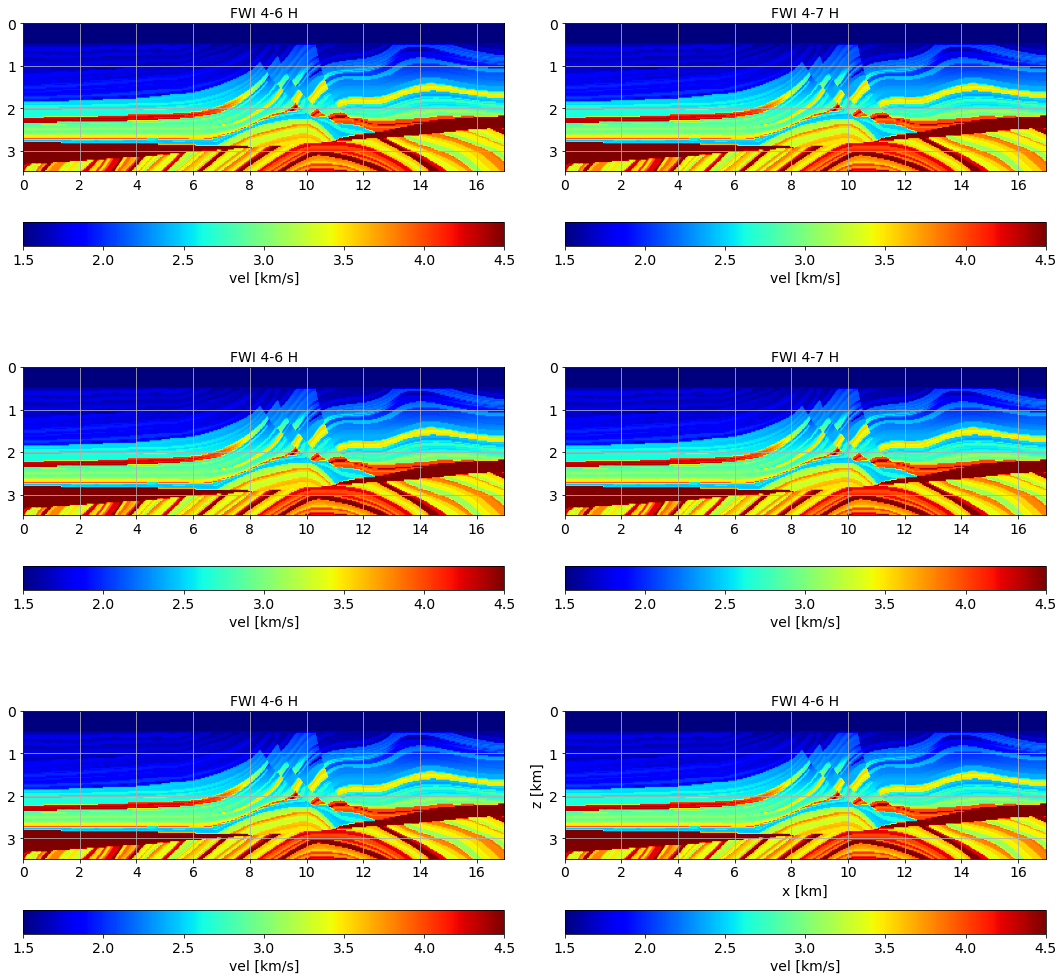

In [34]:
# Read inverted models

vel_true = genericIO.defaultIO.getVector("vel/Marmousi2-trueVel.H")
vel_init = genericIO.defaultIO.getVector("vel/Marmousi2-initVel1.H")
model_fwi = genericIO.defaultIO.getVector("Marmousi2_inv_mod_4_13.H")
model_fwime_s1 = genericIO.defaultIO.getVector("vel/Marmousi2-fwime-inv-mod-spline1.H")
model_fwime_s2 = genericIO.defaultIO.getVector("vel/Marmousi2-fwime-inv-mod-spline2.H")
model_fwime_s3 = genericIO.defaultIO.getVector("vel/Marmousi2-fwime-inv-mod-spline3.H")
model_fwime_noSpline = genericIO.defaultIO.getVector("vel/Marmousi2-fwime-inv-mod-noSpline.H")

# Convert from SEP arrays to numpy arrays
vel_true_nd = vel_true.getNdArray()
vel_init_nd = vel_init.getNdArray()
model_fwi_nd = model_fwi.getNdArray()
model_fwime_s1_nd = vel_true.getNdArray()
model_fwime_s2_nd = vel_true.getNdArray()
model_fwime_s3_nd = vel_true.getNdArray()
model_fwime_noSpline_nd = vel_true.getNdArray()

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plot true velocity model
img0_0 = axs[0,0].imshow(vel_init_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[0,0].set_title("Initial model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img0_0, ax=axs[0,0], orientation="horizontal", label="vel [km/s]")
axs[0,0].grid()
# plt.show()

# Plot initial velocity model
img0_1 = axs[0,1].imshow(model_fwi_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[0,1].set_title("FWI 4-13 Hz"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img0_1, ax=axs[0,1], orientation="horizontal", label="vel [km/s]")
axs[0,1].grid()
# plt.show()

# Plot true velocity model
img1_0 = axs[1,0].imshow(model_fwime_s1_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[1,0].set_title("FWIME spline 1"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img1_0, ax=axs[1,0], orientation="horizontal", label="vel [km/s]")
axs[1,0].grid()
# plt.show()

# Plot initial velocity model
img1_1 = axs[1,1].imshow(model_fwime_s2_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[1,1].set_title("FWIME spline 2"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img0_1, ax=axs[1,1], orientation="horizontal", label="vel [km/s]")
axs[1,1].grid()
# plt.show()

# Plot true velocity model
img2_0 = axs[2,0].imshow(model_fwime_noSpline.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[2,0].set_title("FWIME FD grid"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img2_0, ax=axs[2,0], orientation="horizontal", label="vel [km/s]")
axs[2,0].grid()
# plt.show()

# Plot true velocity model
img2_1 = axs[2,1].imshow(vel_true_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[2,1].set_title("True velocity"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img2_1, ax=axs[2,1], orientation="horizontal", label="vel [km/s]")
axs[2,1].grid()
# plt.show()

plt.tight_layout()


## VI. References

* Martin, G. S., K. J. Marfurt, and S. Larsen, 2002, Marmousi-2: An updated model for the investigation of avo in structurally complex areas, in SEG Technical Program Expanded Abstracts 2002: Society of Exploration Geophysicists, 1979–1982.

* Barnier, G., E. Biondi, R. G. Clapp, and B. Biondi, 2022, Full waveform inversion by model extension: practical applications (manuscript submitted to Geophysics)